In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class, model_dir, lang_class, lang_path = (conf.get(k) for k in ("model_class", "model_dir", "lang_class", "lang_path"))
lang_class = class_from_package("language", lang_class)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class, reward_conf = (conf.get(k) for k in ("reward_class", "reward_conf"))
reward_class = class_from_package("reward", reward_class)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.37, count_rollouts: 2, reward: 0.4286342785752393, node: O=C(NCCSc1nc2ccccc2c1=O)N1CCCC1
1- time: 2.88, count_rollouts: 16, reward: 0.10651115382283119, node: N#Cc1noc(Oc2ccccc2)n1
2- time: 5.08, count_rollouts: 29, reward: 0.6254550298955759, node: Cc1ccc(S(=O)(=O)Nc2ccc(C(=O)NC)cc2)cc1
3- time: 5.88, count_rollouts: 34, reward: 0.40647579080445645, node: ClC(=O)c1cc(Br)c(NC(=O)[C@@H]2CCO2)cc1
4- time: 9.16, count_rollouts: 53, reward: 0.7205539405885091, node: C[C@@H](NC(=O)COc1ccc(Cl)cc1Cl)c1ccccc1
5- time: 9.31, count_rollouts: 54, reward: 0.3028606925135664, node: CN(C)C[C@@H]1CN(C(=O)COc2cccc(F)c2)C1
6- time: 9.47, count_rollouts: 55, reward: 0.7931692596940951, node: CSCn1cc(OC)c([C@@H]2CCC[C@@H]2C)c1C
7- time: 9.63, count_rollouts: 56, reward: -0.3650594925665895, node: Cn1cc(C)cc1NC(=O)CN1CCCOC1
8- time: 9.94, count_rollouts: 58, reward: 0.09712837001255414, node: C=CCN(C)[C@H](NCC(=O)c1ccc(Cl)cc1)C(F)F
9- time: 12.43, count_rollouts: 73, reward: 

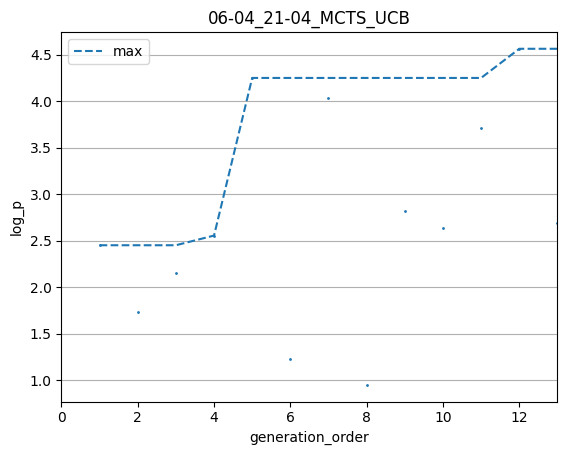

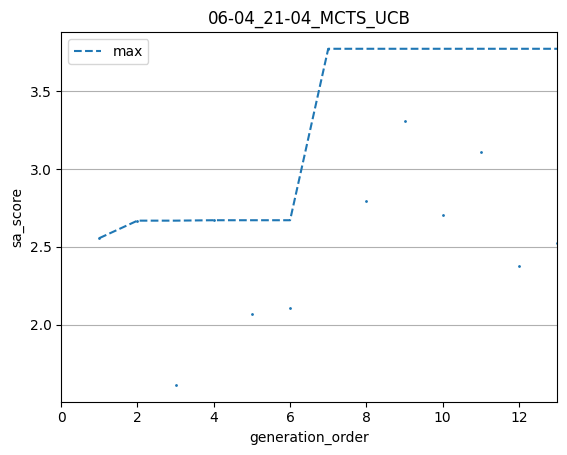

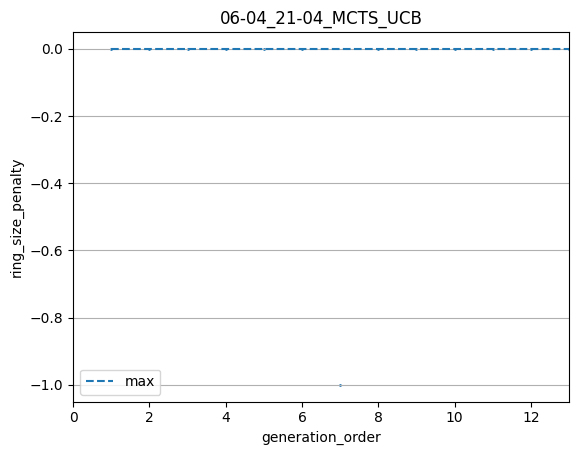

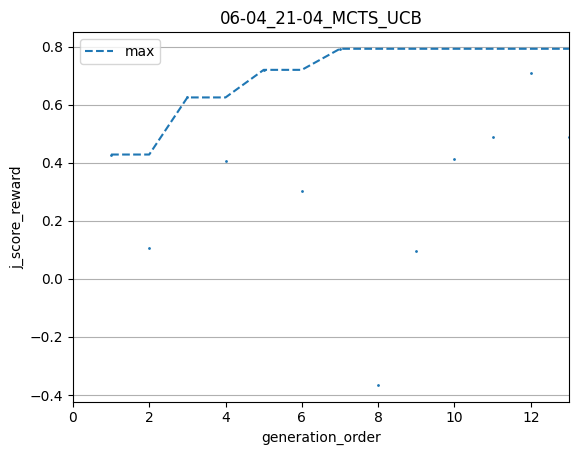

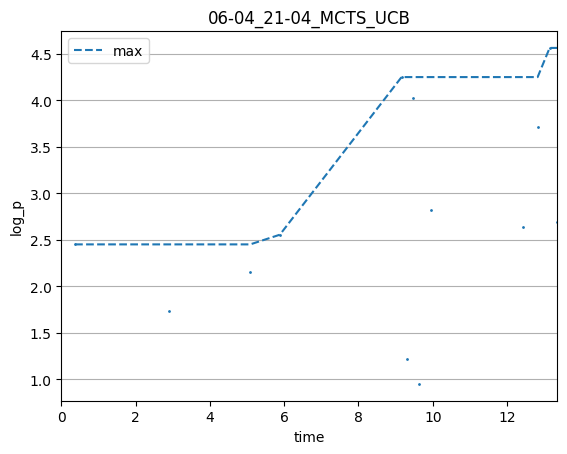

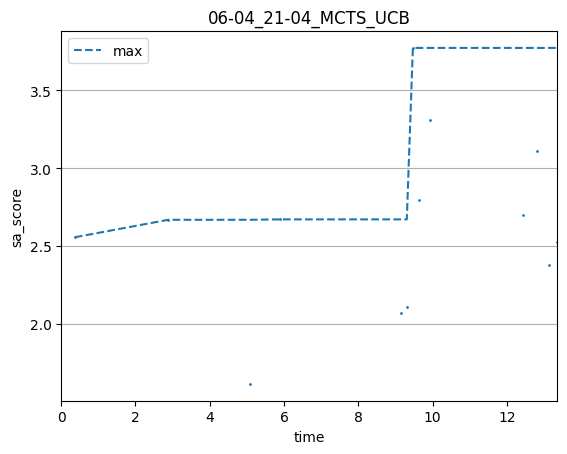

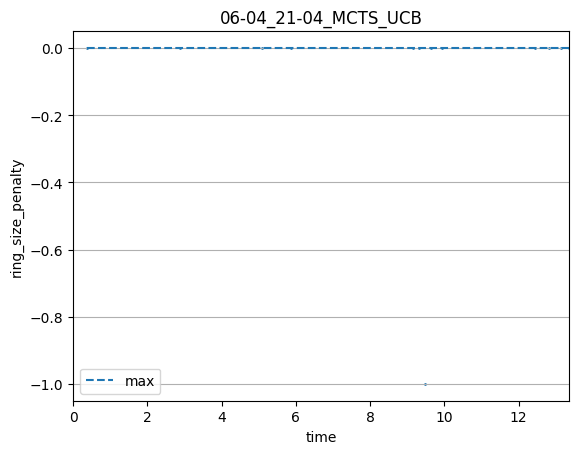

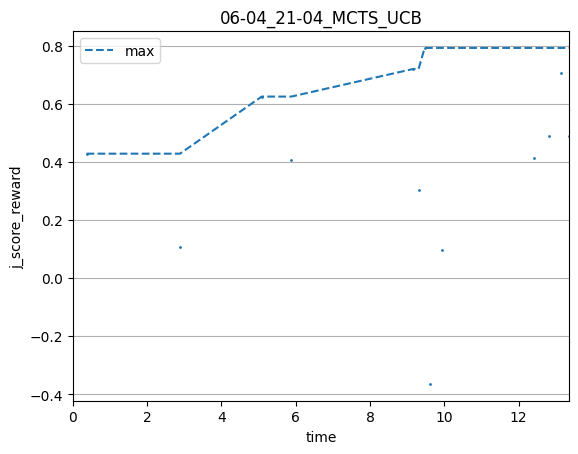

In [4]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)